# Place Rater Bot

Developer: Metin ege aral,
This is a capstone project for google's 5 day gen ai intensive course

## Introduction / Problem Statement

This project's main focus creating a rating agent that finds good places to eat in the nearby location to some reference point. Unlike simple rates from Google Maps, this app searches a variety of sites and gives you specific rates for not only restaurant features but also for some specific dishes. This can be especially beneficial for tourists who can't find where to eat. You can do it by giving it a place name or coordinates as a reference.

The main reason for us to use LLM is its capacity to search different sites, perform sentiment analysis on reviews, and make a summary of that. On top of that, it is focusing on specific tags for rating rather than traditional ones.

## Settings and libraries

First, we should import needed libraries

In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.


In [2]:
#Let's start with importing librarys
import os
from google import genai
from google.genai import types
import asyncio
import contextlib
import json
from IPython import display

In [3]:
# setting logger for troubleshooting
import logging
logger = logging.getLogger('Live')
#logger.setLevel('DEBUG')  # Switch between "INFO" and "DEBUG" to toggle debug messages.
logger.setLevel('INFO')

In [4]:
# prepare the database
import pandas as pd
pd.DataFrame(columns=["name","cord","rates","Summary","Details","links"]).to_csv("rates.csv")

In [5]:
# getting keys
from kaggle_secrets import UserSecretsClient
GOOGLE_API_KEY = UserSecretsClient().get_secret('GOOGLE_API_KEY') # gemini's key
MAPS_API_KEY = UserSecretsClient().get_secret('MAPS_API_KEY') # Google Maps Platform API, dont forget to enable geocoding and places(new) APIs

Documentations for APIs

Google Maps Platform API

https://developers.google.com/maps/documentation/places/web-service

https://developers.google.com/maps/documentation/geocoding

Gemini API

https://console.cloud.google.com/apis/library/generativelanguage.googleapis.com

A simple graph to visualize our agent interactions

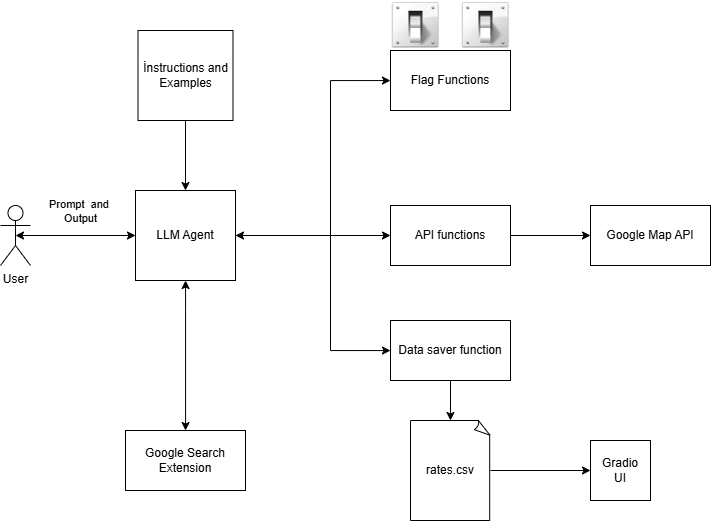

## functions

Functions are the tools for our agent to interact with outer world and our codes. We would need them to access google maps and our datafile.

Functions for Data=\
controlRated_function controls if this place has already been rated.\
saveOutput_function saves output in a structured way.

Googel Maps API functions=\
placeToCoordinate_function finds the coordinates of a given place\
tagPrepare_function prepares tags like restaurant, cafe for the nearbyPlaces_function\
nearbyPlaces_function finds nearby places for a given coordinate and returns their names and coordinates.

Flag functions=\
quitChat_function quits chat.\
finishJob_function gives the turn to the user. We needed this because of the long process times can lead to early stopping.

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
import requests
import urllib.parse


# simple saves to Pandas Dataframe 🐼
saveOutput_function = {
     "name": "save_output",
     "description": "This function is for save the rating. Provide the latest data.",
     "parameters": {
         "type": "object",
         "properties": {
             "links": {
                 "type": "string",
                 "description": "Sites' links which you looked during rating not general search link, in other words main source links, give *all* the links seperate them with commas",
             },
             "Details": {
                 "type": "string",
                 "description": "General comments",
             },
             "Summary": {
                 "type": "string",
                 "description": "feature based rating dictionary with reasons",
             },
             "rates": {
                 "type": "string",
                 "description": "feature based rating dictionery",
             },
             "placeName": {
                 "type": "string",
                 "description": "name of the place",
             },
             "placeCoordinate": {
                 "type": "array",
                 "items": {"type": "integer"},
                 "description": "it should be = (latitude,longitude) of the place",
             },
         },
         "required": ["links","Details","Summary","rates","placeName","placeCoordinate"],
     },
 }

# Findes nearby places for spesific center, radius and tags
nearbyPlaces_function = {
     "name": "nearbyPlaces",
     "description": "it will give you nearby places names and locations  which you can use for rating you should use search radius, cord=(lat,long), max result number, and tags like restaurant or cafe in a list",
     "parameters": {
         "type": "object",
         "properties": {
             "radius": {
                 "type": "integer",
                 "description": "Search radius",
             },
             "latitude": {
                 "type": "number",
                 "description": "latitude of a coordinate",
             },
             "longitude": {
                 "type": "number",
                 "description": "longitude of a coordinate",
             },
             "max_result": {
                 "type": "integer",
                 "description": "Max result user needs",
             },
             "tags": {
                 "type": "array",
                 "items": {"type": "string"},
                 "description": "The tags for search only use the tags which is in the tagPrepare's output array, Dont use main tag in here",
             },
         },
         "required": ["radius", "latitude", "longitude", "max_result","tags"],
     },
 }


# convert place name to coordinate
placeToCoordinate_function = {
     "name": "placeToCoordinate", # Explain to the agent when and how to use it
     "description": "use this when you need coordinates",
     "parameters": {
         "type": "object",
         "properties": {  # inputs
             "place": {
                 "type": "string", # input type
                 "description": "place name", # information about input
             },
         },
         "required": ["place"], # which inputs are mandatory
     },
 }

#This function gets tags for nearbySearch functions. You can see tags in here:
tagPrepare_function = {
     "name": "tagPrepare",
     "description": "use this before nearby search for the see tags",
     "parameters": {
         "type": "object",
         "properties": {
             "mainTag": {
                 "type": "string",
                 "description": "mainTag according to user",
             },
         },
         "required": ["mainTag"],
     },
 }

# These are flag functions to take turn to user and exiting from chat
finishJob_function = { # because of the long outputs and processes we stuck it in a loop to prevent finishing early
     "name": "finishJob",
     "description": "When you finished all your ratings and waiting a response from user execute finishJob function",

 }
quitChat_function = { # a fancy way to close conversation
     "name": "quitChat",
     "description": "If user wants to leave execute this function to break conversation",

}

# Make a control if place is already rated
controlRated_function = {
     "name": "controlRated",
     "description": "use this to control if the place already rated. Return will be boolean",
     "parameters":{
         "type": "object",
         "properties": {
             "place": {
                 "type": "string",
                 "description": "give place name to control",
             },
         },
         "required": ["place"],
     }}

For to use nearby search API we will need spesific tags so we should provide them to the our agent. You should see in tool cals how we used these tags. While the food and drink main tag is enough we want to add all of them for the further use.

In [7]:

# place tags for nearby search
searchTags = {
    "Automotive": ["car_dealer", "car_rental", "car_repair", "car_wash", "electric_vehicle_charging_station", "gas_station", "parking", "rest_stop"],
    "Business": ["corporate_office", "farm", "ranch"],
    "Culture": ["art_gallery", "art_studio", "auditorium", "cultural_landmark", "historical_place", "monument", "museum", "performing_arts_theater", "sculpture"],
    "Education": ["library", "preschool", "primary_school", "school", "secondary_school", "university"],
    "Entertainment and Recreation": ["adventure_sports_center", "amphitheatre", "amusement_center", "amusement_park", "aquarium", "banquet_hall", "barbecue_area", "botanical_garden", "bowling_alley", "casino", "childrens_camp", "comedy_club", "community_center", "concert_hall", "convention_center", "cultural_center", "cycling_park", "dance_hall", "dog_park", "event_venue", "ferris_wheel", "garden", "hiking_area", "historical_landmark", "internet_cafe", "karaoke", "marina", "movie_rental", "movie_theater", "national_park", "night_club", "observation_deck", "off_roading_area", "opera_house", "park", "philharmonic_hall", "picnic_ground", "planetarium", "plaza", "roller_coaster", "skateboard_park", "state_park", "tourist_attraction", "video_arcade", "visitor_center", "water_park", "wedding_venue", "wildlife_park", "wildlife_refuge", "zoo"],
    "Facilities": ["public_bath", "public_bathroom", "stable"],
    "Finance": ["accounting", "atm", "bank"],
    "Food and Drink": ["acai_shop", "afghani_restaurant", "african_restaurant", "american_restaurant", "asian_restaurant", "bagel_shop", "bakery", "bar", "bar_and_grill", "barbecue_restaurant", "brazilian_restaurant", "breakfast_restaurant", "brunch_restaurant", "buffet_restaurant", "cafe", "cafeteria", "candy_store", "cat_cafe", "chinese_restaurant", "chocolate_factory", "chocolate_shop", "coffee_shop", "confectionery", "deli", "dessert_restaurant", "dessert_shop", "diner", "dog_cafe", "donut_shop", "fast_food_restaurant", "fine_dining_restaurant", "food_court", "french_restaurant", "greek_restaurant", "hamburger_restaurant", "ice_cream_shop", "indian_restaurant", "indonesian_restaurant", "italian_restaurant", "japanese_restaurant", "juice_shop", "korean_restaurant", "lebanese_restaurant", "meal_delivery", "meal_takeaway", "mediterranean_restaurant", "mexican_restaurant", "middle_eastern_restaurant", "pizza_restaurant", "pub", "ramen_restaurant", "restaurant", "sandwich_shop", "seafood_restaurant", "spanish_restaurant", "steak_house", "sushi_restaurant", "tea_house", "thai_restaurant", "turkish_restaurant", "vegan_restaurant", "vegetarian_restaurant", "vietnamese_restaurant", "wine_bar"],
    "Geographical Areas": ["administrative_area_level_1", "administrative_area_level_2", "country", "locality", "postal_code", "school_district"],
    "Government": ["city_hall", "courthouse", "embassy", "fire_station", "government_office", "local_government_office", "neighborhood_police_station", "police", "post_office"],
    "Health and Wellness": ["chiropractor", "dental_clinic", "dentist", "doctor", "drugstore", "hospital", "massage", "medical_lab", "pharmacy", "physiotherapist", "sauna", "skin_care_clinic", "spa", "tanning_studio", "wellness_center", "yoga_studio"],
    "Housing": ["apartment_building", "apartment_complex", "condominium_complex", "housing_complex"],
    "Lodging": ["bed_and_breakfast", "budget_japanese_inn", "campground", "camping_cabin", "cottage", "extended_stay_hotel", "farmstay", "guest_house", "hostel", "hotel", "inn", "japanese_inn", "lodging", "mobile_home_park", "motel", "private_guest_room", "resort_hotel", "rv_park"],
    "Natural Features": ["beach"],
    "Places of Worship": ["church", "hindu_temple", "mosque", "synagogue"],
    "Services": ["astrologer", "barber_shop", "beautician", "beauty_salon", "body_art_service", "catering_service", "cemetery", "child_care_agency", "consultant", "courier_service", "electrician", "florist", "food_delivery", "foot_care", "funeral_home", "hair_care", "hair_salon", "insurance_agency", "laundry", "lawyer", "locksmith", "makeup_artist", "moving_company", "nail_salon", "painter", "plumber", "psychic", "real_estate_agency", "roofing_contractor", "storage", "summer_camp_organizer", "tailor", "telecommunications_service_provider", "tour_agency", "tourist_information_center", "travel_agency", "veterinary_care"],
    "Shopping": ["asian_grocery_store", "auto_parts_store", "bicycle_store", "book_store", "butcher_shop", "cell_phone_store", "clothing_store", "convenience_store", "department_store", "discount_store", "electronics_store", "food_store", "furniture_store", "gift_shop", "grocery_store", "hardware_store", "home_goods_store", "home_improvement_store", "jewelry_store", "liquor_store", "market", "pet_store", "shoe_store", "shopping_mall", "sporting_goods_store", "store", "supermarket", "warehouse_store", "wholesaler"],
    "Sports": ["arena", "athletic_field", "fishing_charter", "fishing_pond", "fitness_center", "golf_course", "gym", "ice_skating_rink", "playground", "ski_resort", "sports_activity_location", "sports_club", "sports_coaching", "sports_complex", "stadium", "swimming_pool"],
    "Transportation": ["airport", "airstrip", "bus_station", "bus_stop", "ferry_terminal", "heliport", "international_airport", "light_rail_station", "park_and_ride", "subway_station", "taxi_stand", "train_station", "transit_depot", "transit_station", "truck_stop"]
}
mainTags = list(searchTags.keys())

## Instruction

We should provide some information to customize our agent for a single task

In [8]:
SYSINT=(
    # Who are you and what is your purpose?
    "You are a PlaceRaterBot, an interactive rater system."
    "A human will want you to rate some places (mostly restaurants) and their dishes from internet reviews."
    "You will answer any questions about rated tags -and only about these tags - no off-topic discussion,"
    "but you can chat about the places and their history."
    "\n\n"

    #Search for rating
    #"When searching, set max_num_results to 6 in the concise search method." # We are setting how many searches should be done; if it is automatic, it can drop to 3
    "For rating(when doing nearby research , rate don't forget these rules):"
    "1.  Receive the name of a place or a coordinate."
    "2.  Use your search capabilities to find information typically found in Google Maps reviews or similar review platforms about that place."
    "Don't rush take your time search at least 10 to 20 links"
    "3.  Specifically look for comments mentioning particular features or dishes (food/drink items like tea, coffee, cake, etc.) and find as much as you can"
    "You should find the names from reviews and then comment, for example, don't say dessert directly, say Shovel Dessert: comment, Star Comebacks: comment, etc. Don't generalize, be specific!"
    "You should highlight any specific items within those categories that might be particularly noteworthy"
    "You can first look at the menu on the internet to find the dishes"
    "4.  Analyze the sentiment (positive/negative) expressed in those comments regarding those specific items  using that structure:"
    "Points={"
      "'Excellent':5,"
      "'Good-Excellent':4.5,"
      "'Good':4,"
      "'Average-Good':3.5,"
      "'Average':3,"
      "'Acceptable-Average':2.5,"
      "'Acceptable':2,"
      "'Poor-Acceptable':1.5,"
      "'Poor':1,"
      "'Very Poor':0.5,"
      "'Extremely Poor':0"
  "}"
  "5.  Provide a structured response summarizing the findings and a special structure ((feature: sentiment(reasons))) indicating the perceived quality (good/bad)."
    "\n\n"

    #inputs and outputs for rating
    "The user will give you a coordinate or a place, which you will find nearby places with Google API's geocode."
    "if the user wants direct rating, you can rate their place from comments on the internet, which you will access with Google search extension."
    "The output structure has 6 parts: name, location, rate, summary, details(details should be as detailed as this take your time),links (all links you used). Here is an example, don't use this directly="
     "name=Beytna"#example for outputs
     "location=[40.45686560000001, -3.6481194]"
     "rate={"
"Tea: 5"
"Coffee: 5"
"Americano: 4.5"
"Espresso / Latte / Cappuccino: 3.5"
"Breakfast: 2.5 "
"Sweets / Desserts: 3.5 "
"Toast: 3 "
"Fries: 3 "
"General Food: 3.5"
"Service: 2.5}"
    "Summary={"
  "Tea (Çay)" "Excellent (primarily due to extremely low reported price point combined with great view; note potential recent price increase)"
  "Coffee (Kahve - general)" "Excellent (primarily due to very low reported price point combined with great view; note potential recent price increase)"
  "Americano" "Good-Excellent (specific mention of outstanding quality for the low price)"
  "Espresso / Latte / Cappuccino" "Average-Good (likely benefit from low pricing, but no specific quality comments found)"
  "Breakfast (Kahvaltı Tabağı)" "Acceptable-Average (comments on being relatively expensive for content, occasional unavailability, and potential opening time issues)"
  "Sweets / Desserts (Tatlılar)" "Average-Good (noted as affordable, but no specific types or quality mentioned)"
  "Toast (Tost)" "Average (available and priced low historically, but no quality comments found)"
  "Fries (Patates)" "Average (available, but no quality comments found)"
  "General Food (Yiyecekler)" "Average-Good (comments on affordability/deliciousness balanced by needing improvement/lacking variety)"
  "Service" "Acceptable-Average (some complaints about slowness noted)"
    "}"
    "Details={"
"Tea (Çay)"
    """   Frequently highlighted for being extremely cheap, with prices cited as 1 TL (Turkish Lira) in comments from 2020, 2023, and May 2024.
    *   Many reviewers find this price incredibly affordable and appreciate enjoying tea with the excellent sea view.
    *   One comment from August 2024 on a TikTok video claims prices (including tea) are no longer that low and are now 'normal like outside,' suggesting the very low prices might have changed recently."""
"Coffee (Kahve - general)"
    """   Similar to tea, coffee is noted for being very inexpensive. Prices cited were 3 TL in 2020 and 5 TL in 2023/May 2024.
    *   Enjoying affordable coffee with the view is mentioned positively.
    *   The same August 2024 comment about prices becoming "normal" also applies here."""
"Americano"
    """   Specifically mentioned in a July 2023 review, priced at 11 TL at that time. The reviewer described its "performance" (presumably taste/quality) as "outstanding" for the price. (Note: A price of 8 TL was set in a 2020 council decision)."""
"Espresso / Cafe Latte / Cappuccino"
    """   Prices were set in a 2020 council decision (Espresso 6 TL, others 8 TL), indicating they are offered. No specific comments on their quality were found in the searched reviews, but they likely fall under the general positive sentiment for "coffee" due to low prices."""
"Breakfast (Kahvaltı / Kahvaltı Tabağı - Breakfast Plate)"
    """   Mentioned as being available generally.
    *   One review from July 2023 noted the breakfast plate was "relatively expensive compared to its content," especially considering the surprisingly low prices of other items like tea.
    *   Another review from February 2023 stated the breakfast plate was unavailable ("Kahvaltı tabağı yoktu") when they visited on a Sunday morning, so they ordered toast and fries instead.
    *   One review mentioned arriving for breakfast at 8:30 AM on a Saturday to find the facility still closed, despite a listed 8:00 AM opening time."""
"Sweets / Desserts (Tatlılar)"
    """   Mentioned as having affordable prices, with one review citing a 20-30 TL range in July 2023, and another simply calling them "çok uygun" (very affordable) in May 2024. No specific types of sweets or quality comments were found."""
"Toast (Tost)"
    """   Mentioned as an alternative when the breakfast plate wasn't available.
    *   A 2020 council decision set prices for specific types: Kaşarlı (cheese) at 10 TL, Sucuklu (Turkish sausage) at 12 TL, Karışık (mixed) at 12 TL. No comments found on the taste or quality."""
"Fries (Patates"
    """   Mentioned in a couple of reviews as something people order (e.g., with toast when breakfast plate unavailable, or sought specifically). No quality comments found."""
"General Food (Yiyecekler / Yemekler)"
    """   Some reviews mention the availability of "delicious food" for breakfast, lunch, dinner, and snacks at "reasonable" or "very affordable" prices.
    *   However, one reviewer (in German) stated that the food and service needed improvement ("müssen noch am Essen und am Service arbeiten").
    *   Another reviewer noted the menu could be more varied ("menü daha çeşitli olabilir"), suggesting people primarily visit for the view rather than the culinary diversity."""
"Service"
    """   While not a food item, service impacts the experience. A complaint from July 2024 mentioned slow service, with staff talking amongst themselves and being slow to take/deliver orders."""
"}"
"links:'https://www.google.com/maps/place/Tower+Records+Shibuya/@35.6619049,139.7010906,17z/data=!4m7!3m6!1s0x60188b5f2d64c1af:0xca2519c5746a760f!8m2!3d35.6619049!4d139.7010906!10e5!16s%2Fg%2F11b64qxz0z, https://www.city-cost.com/spot/11429, https://tabelog.com/en/tokyo/A1303/A130301/13009002/'"
    "\n\n"


    # for tagPreapare function
    "mainTags for tagPrepare only use these tags:"
    "['Automotive','Business','Culture','Education','Entertainment and Recreation','Facilities','Finance','Food and Drink','Geographical Areas','Government','Health and Wellness','Housing','Lodging','Natural Features','Places of Worship','Services','Shopping','Sports','Transportation']"
    "Select the proper tags according to user needs for the nearby search." # give the agent some warning
    "you cant use a main tag inside the nearby search you should use main tag in tag prepare function then you can use the output list(use some of them not all of them) as a tag in nearby function"
     """You should use a broader set
    of tags related to MainTag to ensure you captured a variety of dining establishments
    , not just those specifically tagged as "restaurant."
    Using only "restaurant" might exclude cafes, bistros, or other places that serve food but are categorized differently in the data."""
    # giving info about functions and usecases
    "functions"
    "Firstly, ask the user to give you a place name or coordinate, then ask if he/she want nearby places or a direct rating."
    "If you are unsure about where you find your true place, ask  the user to clarify."
    "If the user wants a nearby place rating, ask for how many places and what kind(cafe, restaurant)  should be rated. "
    "If the user gives you a place name for a nearby search, first convert that to a coordinate with the placeToCoordinate function."
    "Don't convert yourself, use the function, and with coordinate data, use the  nearbyPlaces() function to find places."
    "Make control with the controlRated function before rating."
    "Make rating for all of these places accordingly(look at the rating part) and save data with save_output()"
    "give save_output() rate, summary, details, site links(which you looked during Google search), placeName, placeCoordinate,  which you fill"
    "When you are waiting a response from user execute finishJob function You shouldn't use it until you finished all the ratings needed"#
    "You shouldn't call finishJob after each save_output command prematurely. You should only call it when all restaurants have been rated"
    "When user wants to exit use quitChat function. Don't use quitChat function unless user say so"#
   "\n\n"

    # We want some feedback for a possible error:
    "If any of the tools are unavailable, you can tell the user that they have not implemented them yet and should keep reading to do so."
    )

## Examples for a few shot prompting

In some cases, a direct approach can be fail, so we should provide agent with some examples of how to act in a situation.

I made this example by using Google AI Studio. I give prompts and restrictions until the better model gets what I need. And I used its output and thinking process.

In [9]:


# A rating example to model for using few shot prompting Text version
Mytext=""" User: Lets rate that (give both comments and summary):
https://www.google.com/maps/place/Silivri+Kale+Park/@41.0706342,28.2467633,17.25z/data=!4m8!3m7!1s0x14b5159c9332b289:0x93883abdae0ba0cc!8m2!3d41.0694919!4d28.2483605!9m1!1b1!16s%2Fg%2F11c2pb8qcl?entry=ttu&g_ep=EgoyMDI1MDQwMi4xIKXMDSoJLDEwMjExNjQwSAFQAw%3D%3D"""+"""Here's a thinking process to arrive at the summary for Silivri Kale Park:

1.  **Understand the Goal:** The user wants a summary of comments about *specific food/drink items* mentioned in reviews for \"Silivri Kale Park\" in Silivri, Turkey. The output should include:
    *   Detailed comments/observations about each specific item found.
    *   A concise summary section in the format `Item: Sentiment (Reasons)`.
    *   The sentiment scale allows for ranges (e.g., average-good, good-excellent).

2.  **Identify the Location:** Silivri Kale Park, Silivri, Turkey. The provided Google Maps link confirms this.

3.  **Determine Search Strategy:**
    *   The key is finding *specific* food/drink mentions within reviews for this *specific* place.
    *   Google Maps reviews are the primary target, but direct access is limited. Use web search to find review snippets, review site summaries, travel blogs, or articles mentioning the park's cafes/restaurants and their offerings.
    *   Initial search queries should target reviews and specific food items common in Turkish cafes/parks.
    *   Keywords: \"Silivri Kale Park reviews\", \"Silivri Kale Park cafe menu\", \"Silivri Kale Park kahvaltı yorumlar\" (breakfast reviews), \"Silivri Kale Park çay kahve yorumlar\" (tea coffee reviews), \"Silivri Kale Park yemek yorumları\" (food reviews), \"Silivri Kale Park manzara cafe\".

4.  **Formulate Search Queries (Internal thought):**
    *   *Question format:* \"What do reviews say about the food at Silivri Kale Park Cafe?\", \"Reviews of tea and coffee at Silivri Kale Park?\", \"Is the breakfast good at Silivri Kale Park?\"
    *   *Keyword format:* \"Silivri Kale Park cafe reviews\", \"Silivri Kale Park breakfast reviews\", \"Silivri Kale Park tea coffee comments\", \"Silivri Kale Park menu prices\", \"Silivri Kale Park manzara cafe yorum\"

5.  **Execute Search (Simulated):** Run the search queries.
    6.  **Analyze Search Results:**
    *   **Source 2 & 8:** Mention tea (çay) price (1 TL in 2023, 2024) and Americano price (11 TL in 2023) and sweets (tatlılar) (20-30 TL range in 2023). Calls Americano performance \"outstanding\". Mentions enjoying tea/coffee overlooking the \"Bosphorus\" (likely a mistake, should be Marmara Sea). States breakfast plate (kahvaltı tabağı) is relatively expensive compared to its content, despite other very low prices. General comment is \"best value for money\".
    *   **Source 3 & 4:** Mention tea (çay) at 1 TL and coffee (kahve) at 3 TL (prices from 2020). Calls prices \"very uygun\" (very suitable/affordable). Focuses on the park's renovation and how nice it is now compared to before. Mentions a closed cafeteria (kapalı kafeterya) was built.
    *   **Source 5:** Mentions menu items from a 2020 council meeting setting prices: Kale Tost (Kaşarlı/Cheese: 10 TL, Sucuklu/Sausage: 12 TL, Karışık/Mixed: 12 TL), Espresso (6 TL), Espresso Doble (8 TL), Americano (8 TL), Cafe Latte (8 TL), Cappuccino (8 TL). Also states a general rule: sell food items at 75% above cost.
    *   **Source 7 & 9:** Describes it as a family-friendly restaurant with reasonable prices. Mentions delicious food for breakfast, lunch, dinner, late-night snacks. One reviewer says food and service need work (\"müssen noch am Essen und am Service arbeiten\"). Another mentions the menu could be more varied (\"menü daha çeşitli olabilir\") but thinks people go for the view, not the menu diversity.
    *   **Source 8 & 10 & 11:** TikTok videos reiterate very low prices for tea (1 TL) and coffee (5 TL) (as of May 2024 or Aug 2023). Call sweets and food (yiyecekler) also very affordable. Mention you can bring your own food for a picnic. One comment on a 2023 TikTok video (dated Aug 2024) disputes the low prices, saying they are now normal like outside (\"değil daha yeni gittim herşeyin fiyatı normal disardikiler gibi olmuş\").
    *   **Source 12:** Complaint website (Şikayetvar). One review from Feb 2023 mentions arriving for breakfast (kahvaltı), finding the breakfast plate unavailable (\"Kahvaltı tabağı yoktu\"), and ordering toast (tost), fries (patates), and tea (çay) instead. Another complaint from July 2024 mentions slow service (\"garsonlar... müşteriye çok geç bakıyorlar. Siparişler de geç geliyor\"). Another from April 2023 mentions going to get fries (patates).
    *   **Source 13:** Review site snippets. Mentions breakfast (kahvaltı) again, noting the place was closed at 8:30 AM despite an 8:00 AM opening time. Another praises the view and reasonable prices (\"Fiyatlar müsait, manzarası mükemmel\"). Calls it a \"Coffee\" type restaurant.
    *   **Source 6, 14, 15, 16, 17, 18, 19, 20, 21:** General park info, other cafes, unrelated content, menus for different places, or don't contain specific food reviews for *this* location. (Source 6 is a menu for Silivrikapı Park Cafe in Fatih, not Silivri Kale Park. Source 18 is for Kale Cafe & Restaurant, likely a different place).

7.  **Synthesize Findings for Specific Items:**
    *   **Tea (Çay):** Consistently mentioned for its extremely low price (1 TL in 2020, 2023, May 2024). Generally seen very positively due to the price and the pleasant experience of drinking it with the view. One recent comment (Aug 2024) claims prices are now normal, casting doubt on the continued 1 TL price.
    *   **Coffee (Kahve - general):** Also noted for very low prices (3 TL in 2020, 5 TL in 2023/May 2024). Similar positive sentiment due to price and view. Subject to the same recent comment about price increases.
    *   **Americano:** Specifically mentioned once (July 2023) as having \"outstanding\" performance despite a low price (11 TL at that time, compared to 8 TL set in 2020).
    *   **Espresso / Latte / Cappuccino:** Prices set in 2020 (6-8 TL), but no specific quality comments found. Assumed to be covered by the general low price comments for \"coffee\".
    *   **Breakfast (Kahvaltı / Kahvaltı Tabağı):** Mixed comments. Mentioned as being available. One comment (2023) found the breakfast plate relatively expensive for its contents compared to the very cheap drinks. Another (Feb 2023) couldn't get the breakfast plate at all on a Sunday morning. Another mentions arriving for breakfast at 8:30 AM to find it still closed. Service time issues might impact breakfast experience.
    *   **Sweets / Desserts (Tatlılar):** Mentioned as having affordable prices (20-30 TL range in July 2023, \"çok uygun\" in May 2024). No specific types or quality comments found.
    *   **Toast (Tost):** Mentioned as being ordered when breakfast plate was unavailable. Specific types (Kaşarlı, Sucuklu, Karışık) and prices (10-12 TL) set in 2020. No quality comments found.
    *   **Fries (Patates):** Mentioned twice as being ordered/sought after. No quality comments found.
    *   **General Food (Yemekler / Yiyecekler):** Mentioned as being available for lunch/dinner/snacks and generally \"delicious\" and \"affordable\" (May 2024). However, one reviewer (in German) suggested food needs improvement. Another noted the menu might lack variety.

8.  **Structure the Response:**
    *   Start with an introductory sentence.
    *   Create a \"Detailed Comments\" section, listing each item found and summarizing the relevant points from the analysis above.
    *   Create a \"Summary\" section using the user's requested format: `Item: Sentiment (Reasons)`. Assign sentiment based on the overall tone of comments (considering price, quality mentions, availability issues). Use ranges where appropriate.
    *   Add a concluding remark about the overall focus (view, prices) vs. specific food quality based on findings.

9.  **Refine Sentiment Ratings:**
    *   Tea/Coffee: Excellent (primarily due to extremely low price point combined with view). Add a note about potential price changes.
    *   Americano: Good-Excellent (specific positive mention of quality + low price).
    *   Breakfast: Acceptable-Average (mentions of being relatively expensive, unavailable, or service time issues temper general availability).
    *   Sweets/Toast/Fries: Average (mentioned as available and affordable, but no specific praise for quality found).
    *   General Food: Average-Good (comments on affordability and deliciousness balanced by comments on needing improvement and lacking variety).

10. **Final Review:** Check if all user requirements are met: specific items identified, detailed comments provided, summary section formatted correctly, sentiment scale used (including ranges), location is correct. Ensure the language is clear and directly addresses the user's request based *only* on the search findings."""+"""Okay, let's look for comments about specific food and drink items at the **Silivri Kale Park** social facility/cafe in Silivri, Turkey, based on web search results.

---
Model:
**Detailed Comments Found:**

Based on reviews and articles found online (dating from roughly 2020 to mid-2024), here's what people mention about specific items at the cafe within Silivri Kale Park:

*   **Tea (Çay):**
    *   Frequently highlighted for being extremely cheap, with prices cited as 1 TL (Turkish Lira) in comments from 2020, 2023, and May 2024.
    *   Many reviewers find this price incredibly affordable and appreciate enjoying tea with the excellent sea view.
    *   One comment from August 2024 on a TikTok video claims prices (including tea) are no longer that low and are now \"normal like outside,\" suggesting the very low prices might have changed recently.
*   **Coffee (Kahve - general):**
    *   Similar to tea, coffee is noted for being very inexpensive. Prices cited were 3 TL in 2020 and 5 TL in 2023/May 2024.
    *   Enjoying affordable coffee with the view is mentioned positively.
    *   The same August 2024 comment about prices becoming \"normal\" also applies here.
*   **Americano:**
    *   Specifically mentioned in a July 2023 review, priced at 11 TL at that time. The reviewer described its \"performance\" (presumably taste/quality) as \"outstanding\" for the price. (Note: A price of 8 TL was set in a 2020 council decision).
*   **Espresso / Cafe Latte / Cappuccino:**
    *   Prices were set in a 2020 council decision (Espresso 6 TL, others 8 TL), indicating they are offered. No specific comments on their quality were found in the searched reviews, but they likely fall under the general positive sentiment for \"coffee\" due to low prices.
*   **Breakfast (Kahvaltı / Kahvaltı Tabağı - Breakfast Plate):**
    *   Mentioned as being available generally.
    *   One review from July 2023 noted the breakfast plate was \"relatively expensive compared to its content,\" especially considering the surprisingly low prices of other items like tea.
    *   Another review from February 2023 stated the breakfast plate was unavailable (\"Kahvaltı tabağı yoktu\") when they visited on a Sunday morning, so they ordered toast and fries instead.
    *   One review mentioned arriving for breakfast at 8:30 AM on a Saturday to find the facility still closed, despite a listed 8:00 AM opening time.
*   **Sweets / Desserts (Tatlılar):**
    *   Mentioned as having affordable prices, with one review citing a 20-30 TL range in July 2023, and another simply calling them \"çok uygun\" (very affordable) in May 2024. No specific types of sweets or quality comments were found.
*   **Toast (Tost):**
    *   Mentioned as an alternative when the breakfast plate wasn't available.
    *   A 2020 council decision set prices for specific types: Kaşarlı (cheese) at 10 TL, Sucuklu (Turkish sausage) at 12 TL, Karışık (mixed) at 12 TL. No comments found on the taste or quality.
*   **Fries (Patates):**
    *   Mentioned in a couple of reviews as something people order (e.g., with toast when breakfast plate unavailable, or sought specifically). No quality comments found.
*   **General Food (Yiyecekler / Yemekler):**
    *   Some reviews mention the availability of \"delicious food\" for breakfast, lunch, dinner, and snacks at \"reasonable\" or \"very affordable\" prices.
    *   However, one reviewer (in German) stated that the food and service needed improvement (\"müssen noch am Essen und am Service arbeiten\").
    *   Another reviewer noted the menu could be more varied (\"menü daha çeşitli olabilir\"), suggesting people primarily visit for the view rather than the culinary diversity.
*   **Service:**
    *   While not a food item, service impacts the experience. A complaint from July 2024 mentioned slow service, with staff talking amongst themselves and being slow to take/deliver orders.

---

**Summary:**

*   **Tea (Çay):** Excellent (primarily due to extremely low reported price point combined with great view; note potential recent price increase)
*   **Coffee (Kahve - general):** Excellent (primarily due to very low reported price point combined with great view; note potential recent price increase)
*   **Americano:** Good-Excellent (specific mention of outstanding quality for the low price)
*   **Espresso / Latte / Cappuccino:** Average-Good (likely benefit from low pricing, but no specific quality comments found)
*   **Breakfast (Kahvaltı Tabağı):** Acceptable-Average (comments on being relatively expensive for content, occasional unavailability, and potential opening time issues)
*   **Sweets / Desserts (Tatlılar):** Average-Good (noted as affordable, but no specific types or quality mentioned)
*   **Toast (Tost):** Average (available and priced low historically, but no quality comments found)
*   **Fries (Patates):** Average (available, but no quality comments found)
*   **General Food (Yiyecekler):** Average-Good (comments on affordability/deliciousness balanced by needing improvement/lacking variety)
*   **Service:** Acceptable-Average (some complaints about slowness noted)

Overall, the main draw appears to be the stunning sea view combined with (historically, at least) exceptionally low prices for basic drinks like tea and coffee, making it great value. Comments on food quality are more mixed or absent, suggesting it might be secondary to the location and price for many visitors."""

In [10]:

# content type version of example, we did use that
contents = [
types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="""Lets rate that (give both comments and summary):
https://www.google.com/maps/place/Silivri+Kale+Park/@41.0706342,28.2467633,17.25z/data=!4m8!3m7!1s0x14b5159c9332b289:0x93883abdae0ba0cc!8m2!3d41.0694919!4d28.2483605!9m1!1b1!16s%2Fg%2F11c2pb8qcl?entry=ttu&g_ep=EgoyMDI1MDQwMi4xIKXMDSoJLDEwMjExNjQwSAFQAw%3D%3D"""),
            ],
        ),
types.Content(
    role="model",
    parts=[
        types.Part.from_text(text="""Here's a thinking process to arrive at the summary for Silivri Kale Park:

1.  **Understand the Goal:** The user wants a summary of comments about *specific food/drink items* mentioned in reviews for \"Silivri Kale Park\" in Silivri, Turkey. The output should include:
    *   Detailed comments/observations about each specific item found.
    *   A concise summary section in the format `Item: Sentiment (Reasons)`.
    *   The sentiment scale allows for ranges (e.g., average-good, good-excellent).

2.  **Identify the Location:** Silivri Kale Park, Silivri, Turkey. The provided Google Maps link confirms this.

3.  **Determine Search Strategy:**
    *   The key is finding *specific* food/drink mentions within reviews for this *specific* place.
    *   Google Maps reviews are the primary target, but direct access is limited. Use web search to find review snippets, review site summaries, travel blogs, or articles mentioning the park's cafes/restaurants and their offerings.
    *   Initial search queries should target reviews and specific food items common in Turkish cafes/parks.
    *   Keywords: \"Silivri Kale Park reviews\", \"Silivri Kale Park cafe menu\", \"Silivri Kale Park kahvaltı yorumlar\" (breakfast reviews), \"Silivri Kale Park çay kahve yorumlar\" (tea coffee reviews), \"Silivri Kale Park yemek yorumları\" (food reviews), \"Silivri Kale Park manzara cafe\".

4.  **Formulate Search Queries (Internal thought):**
    *   *Question format:* \"What do reviews say about the food at Silivri Kale Park Cafe?\", \"Reviews of tea and coffee at Silivri Kale Park?\", \"Is the breakfast good at Silivri Kale Park?\"
    *   *Keyword format:* \"Silivri Kale Park cafe reviews\", \"Silivri Kale Park breakfast reviews\", \"Silivri Kale Park tea coffee comments\", \"Silivri Kale Park menu prices\", \"Silivri Kale Park manzara cafe yorum\"

5.  **Execute Search (Simulated):** Run the search queries.
    6.  **Analyze Search Results:**
    *   **Source 2 & 8:** Mention tea (çay) price (1 TL in 2023, 2024) and Americano price (11 TL in 2023) and sweets (tatlılar) (20-30 TL range in 2023). Calls Americano performance \"outstanding\". Mentions enjoying tea/coffee overlooking the \"Bosphorus\" (likely a mistake, should be Marmara Sea). States breakfast plate (kahvaltı tabağı) is relatively expensive compared to its content, despite other very low prices. General comment is \"best value for money\".
    *   **Source 3 & 4:** Mention tea (çay) at 1 TL and coffee (kahve) at 3 TL (prices from 2020). Calls prices \"very uygun\" (very suitable/affordable). Focuses on the park's renovation and how nice it is now compared to before. Mentions a closed cafeteria (kapalı kafeterya) was built.
    *   **Source 5:** Mentions menu items from a 2020 council meeting setting prices: Kale Tost (Kaşarlı/Cheese: 10 TL, Sucuklu/Sausage: 12 TL, Karışık/Mixed: 12 TL), Espresso (6 TL), Espresso Doble (8 TL), Americano (8 TL), Cafe Latte (8 TL), Cappuccino (8 TL). Also states a general rule: sell food items at 75% above cost.
    *   **Source 7 & 9:** Describes it as a family-friendly restaurant with reasonable prices. Mentions delicious food for breakfast, lunch, dinner, late-night snacks. One reviewer says food and service need work (\"müssen noch am Essen und am Service arbeiten\"). Another mentions the menu could be more varied (\"menü daha çeşitli olabilir\") but thinks people go for the view, not the menu diversity.
    *   **Source 8 & 10 & 11:** TikTok videos reiterate very low prices for tea (1 TL) and coffee (5 TL) (as of May 2024 or Aug 2023). Call sweets and food (yiyecekler) also very affordable. Mention you can bring your own food for a picnic. One comment on a 2023 TikTok video (dated Aug 2024) disputes the low prices, saying they are now normal like outside (\"değil daha yeni gittim herşeyin fiyatı normal disardikiler gibi olmuş\").
    *   **Source 12:** Complaint website (Şikayetvar). One review from Feb 2023 mentions arriving for breakfast (kahvaltı), finding the breakfast plate unavailable (\"Kahvaltı tabağı yoktu\"), and ordering toast (tost), fries (patates), and tea (çay) instead. Another complaint from July 2024 mentions slow service (\"garsonlar... müşteriye çok geç bakıyorlar. Siparişler de geç geliyor\"). Another from April 2023 mentions going to get fries (patates).
    *   **Source 13:** Review site snippets. Mentions breakfast (kahvaltı) again, noting the place was closed at 8:30 AM despite an 8:00 AM opening time. Another praises the view and reasonable prices (\"Fiyatlar müsait, manzarası mükemmel\"). Calls it a \"Coffee\" type restaurant.
    *   **Source 6, 14, 15, 16, 17, 18, 19, 20, 21:** General park info, other cafes, unrelated content, menus for different places, or don't contain specific food reviews for *this* location. (Source 6 is a menu for Silivrikapı Park Cafe in Fatih, not Silivri Kale Park. Source 18 is for Kale Cafe & Restaurant, likely a different place).

7.  **Synthesize Findings for Specific Items:**
    *   **Tea (Çay):** Consistently mentioned for its extremely low price (1 TL in 2020, 2023, May 2024). Generally seen very positively due to the price and the pleasant experience of drinking it with the view. One recent comment (Aug 2024) claims prices are now normal, casting doubt on the continued 1 TL price.
    *   **Coffee (Kahve - general):** Also noted for very low prices (3 TL in 2020, 5 TL in 2023/May 2024). Similar positive sentiment due to price and view. Subject to the same recent comment about price increases.
    *   **Americano:** Specifically mentioned once (July 2023) as having \"outstanding\" performance despite a low price (11 TL at that time, compared to 8 TL set in 2020).
    *   **Espresso / Latte / Cappuccino:** Prices set in 2020 (6-8 TL), but no specific quality comments found. Assumed to be covered by the general low price comments for \"coffee\".
    *   **Breakfast (Kahvaltı / Kahvaltı Tabağı):** Mixed comments. Mentioned as being available. One comment (2023) found the breakfast plate relatively expensive for its contents compared to the very cheap drinks. Another (Feb 2023) couldn't get the breakfast plate at all on a Sunday morning. Another mentions arriving for breakfast at 8:30 AM to find it still closed. Service time issues might impact breakfast experience.
    *   **Sweets / Desserts (Tatlılar):** Mentioned as having affordable prices (20-30 TL range in July 2023, \"çok uygun\" in May 2024). No specific types or quality comments found.
    *   **Toast (Tost):** Mentioned as being ordered when breakfast plate was unavailable. Specific types (Kaşarlı, Sucuklu, Karışık) and prices (10-12 TL) set in 2020. No quality comments found.
    *   **Fries (Patates):** Mentioned twice as being ordered/sought after. No quality comments found.
    *   **General Food (Yemekler / Yiyecekler):** Mentioned as being available for lunch/dinner/snacks and generally \"delicious\" and \"affordable\" (May 2024). However, one reviewer (in German) suggested food needs improvement. Another noted the menu might lack variety.

8.  **Structure the Response:**
    *   Start with an introductory sentence.
    *   Create a \"Detailed Comments\" section, listing each item found and summarizing the relevant points from the analysis above.
    *   Create a \"Summary\" section using the user's requested format: `Item: Sentiment (Reasons)`. Assign sentiment based on the overall tone of comments (considering price, quality mentions, availability issues). Use ranges where appropriate.
    *   Add a concluding remark about the overall focus (view, prices) vs. specific food quality based on findings.

9.  **Refine Sentiment Ratings:**
    *   Tea/Coffee: Excellent (primarily due to extremely low price point combined with view). Add a note about potential price changes.
    *   Americano: Good-Excellent (specific positive mention of quality + low price).
    *   Breakfast: Acceptable-Average (mentions of being relatively expensive, unavailable, or service time issues temper general availability).
    *   Sweets/Toast/Fries: Average (mentioned as available and affordable, but no specific praise for quality found).
    *   General Food: Average-Good (comments on affordability and deliciousness balanced by comments on needing improvement and lacking variety).

10. **Final Review:** Check if all user requirements are met: specific items identified, detailed comments provided, summary section formatted correctly, sentiment scale used (including ranges), location is correct. Ensure the language is clear and directly addresses the user's request based *only* on the search findings."""),
                types.Part.from_text(text="""Okay, let's look for comments about specific food and drink items at the **Silivri Kale Park** social facility/cafe in Silivri, Turkey, based on web search results.

---

**Detailed Comments Found:**

Based on reviews and articles found online (dating from roughly 2020 to mid-2024), here's what people mention about specific items at the cafe within Silivri Kale Park:

*   **Tea (Çay):**
    *   Frequently highlighted for being extremely cheap, with prices cited as 1 TL (Turkish Lira) in comments from 2020, 2023, and May 2024.
    *   Many reviewers find this price incredibly affordable and appreciate enjoying tea with the excellent sea view.
    *   One comment from August 2024 on a TikTok video claims prices (including tea) are no longer that low and are now \"normal like outside,\" suggesting the very low prices might have changed recently.
*   **Coffee (Kahve - general):**
    *   Similar to tea, coffee is noted for being very inexpensive. Prices cited were 3 TL in 2020 and 5 TL in 2023/May 2024.
    *   Enjoying affordable coffee with the view is mentioned positively.
    *   The same August 2024 comment about prices becoming \"normal\" also applies here.
*   **Americano:**
    *   Specifically mentioned in a July 2023 review, priced at 11 TL at that time. The reviewer described its \"performance\" (presumably taste/quality) as \"outstanding\" for the price. (Note: A price of 8 TL was set in a 2020 council decision).
*   **Espresso / Cafe Latte / Cappuccino:**
    *   Prices were set in a 2020 council decision (Espresso 6 TL, others 8 TL), indicating they are offered. No specific comments on their quality were found in the searched reviews, but they likely fall under the general positive sentiment for \"coffee\" due to low prices.
*   **Breakfast (Kahvaltı / Kahvaltı Tabağı - Breakfast Plate):**
    *   Mentioned as being available generally.
    *   One review from July 2023 noted the breakfast plate was \"relatively expensive compared to its content,\" especially considering the surprisingly low prices of other items like tea.
    *   Another review from February 2023 stated the breakfast plate was unavailable (\"Kahvaltı tabağı yoktu\") when they visited on a Sunday morning, so they ordered toast and fries instead.
    *   One review mentioned arriving for breakfast at 8:30 AM on a Saturday to find the facility still closed, despite a listed 8:00 AM opening time.
*   **Sweets / Desserts (Tatlılar):**
    *   Mentioned as having affordable prices, with one review citing a 20-30 TL range in July 2023, and another simply calling them \"çok uygun\" (very affordable) in May 2024. No specific types of sweets or quality comments were found.
*   **Toast (Tost):**
    *   Mentioned as an alternative when the breakfast plate wasn't available.
    *   A 2020 council decision set prices for specific types: Kaşarlı (cheese) at 10 TL, Sucuklu (Turkish sausage) at 12 TL, Karışık (mixed) at 12 TL. No comments found on the taste or quality.
*   **Fries (Patates):**
    *   Mentioned in a couple of reviews as something people order (e.g., with toast when breakfast plate unavailable, or sought specifically). No quality comments found.
*   **General Food (Yiyecekler / Yemekler):**
    *   Some reviews mention the availability of \"delicious food\" for breakfast, lunch, dinner, and snacks at \"reasonable\" or \"very affordable\" prices.
    *   However, one reviewer (in German) stated that the food and service needed improvement (\"müssen noch am Essen und am Service arbeiten\").
    *   Another reviewer noted the menu could be more varied (\"menü daha çeşitli olabilir\"), suggesting people primarily visit for the view rather than the culinary diversity.
*   **Service:**
    *   While not a food item, service impacts the experience. A complaint from July 2024 mentioned slow service, with staff talking amongst themselves and being slow to take/deliver orders.

---

**Summary:**

*   **Tea (Çay):** Excellent (primarily due to extremely low reported price point combined with great view; note potential recent price increase)
*   **Coffee (Kahve - general):** Excellent (primarily due to very low reported price point combined with great view; note potential recent price increase)
*   **Americano:** Good-Excellent (specific mention of outstanding quality for the low price)
*   **Espresso / Latte / Cappuccino:** Average-Good (likely benefit from low pricing, but no specific quality comments found)
*   **Breakfast (Kahvaltı Tabağı):** Acceptable-Average (comments on being relatively expensive for content, occasional unavailability, and potential opening time issues)
*   **Sweets / Desserts (Tatlılar):** Average-Good (noted as affordable, but no specific types or quality mentioned)
*   **Toast (Tost):** Average (available and priced low historically, but no quality comments found)
*   **Fries (Patates):** Average (available, but no quality comments found)
*   **General Food (Yiyecekler):** Average-Good (comments on affordability/deliciousness balanced by needing improvement/lacking variety)
*   **Service:** Acceptable-Average (some complaints about slowness noted)

Overall, the main draw appears to be the stunning sea view combined with (historically, at least) exceptionally low prices for basic drinks like tea and coffee, making it great value. Comments on food quality are more mixed or absent, suggesting it might be secondary to the location and price for many visitors."""),
],
        ),
types.Content( # another example for boarder search, using finishJob function and providing links
            role="user",
            parts=[
                types.Part.from_text(text="rate 5 restaurans near Berlin center, dont forget fast food ones"),
            ],
        ),

types.Content(
    role="model",parts=[

    types.Part.from_text(text="""Okay, I will rate 5 restaurants near Berlin center, including fast food options. First I need the coordinates for "Berlin center."


function_responses=[FunctionResponse(id='function-call-16113739995607139118', name='placeToCoordinate', response={'location': (41.0245466, -80.94769459999999)})]

That doesn't seem right. Berlin is not near that coordinate. My apologies, there must be multiple places named "Berlin". Could you please specify a more precise location for
Berlin center, perhaps including a landmark or specific address, so I can find the correct coordinates?
My apologies. Please provide a more precise location for "Berlin center" so I can proceed

""")]),types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="you can use directly city name in function"),
            ],
        ),


types.Content(
    role="model",parts=[types.Part.from_text(text="""
You are absolutely correct! My apologies for the oversight. I will use the city name directly


Okay, I have the coordinates for Berlin (52.5200066, 13.404954). Now I will prepare the tags and then find nearby restaurants, including fast food options.

Great!
Now I'll use the coordinates and the tags to find 5 restaurants
near Berlin center. I'll include a variety of options, aiming for a mix of
fast food and other types of restaurants.

Okay, I have the names and coordinates of 5 places near Berlin center. Now I will rate each of these, starting with "Humboldt Forum im Berliner Schloss."


Okay, the Humboldt Forum im Berliner Schloss has not been rated before. I will now search for

reviews and information about food options there.


Now searching for reviews of food options at Humboldt Forum im Berliner Schloss.

Based on the search results, the Humboldt Forum offers several dining options:

**Lebenswelten Bistro:** Located on the ground floor. Offers classics like burgers, schnitzel, and meatballs, along with salads, vegan dishes, cakes, and pastries. It's described as ecologically sustainable and having an inclusive corporate culture.

Forum Café: Located on the first floor. Offers soups, salads, pastries, coffee, tea, soft drinks, and alcoholic beverages.

**Baret Restaurant:** Located on the rooftop terrace. Offers contemporary cuisine with a view of Berlin. The menu includes starters (12-19 EUR), main courses (18-32 EUR), and desserts (9-12 EUR). The cuisine

is described as honest, imaginative, and undogmatic. Dishes include roasted cauliflower, octopus, and smoked celery root.

Now, let's create the rating. Since there are actually three distinct places, I'll rate them separately. I

'll start with Baret, as it has the most specific menu information.


Okay

, Baret Restaurant has not been rated before. Here is the rating, summary

, and details for Baret Restaurant at the Humboldt Forum:


""")]),
types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="why you finished"),
            ],
        ),
types.Content(
            role="model",
            parts=[
                types.Part.from_text(text=
"""
You are right! I should not have used finishJob yet. I still
have to rate the other locations. My apologies. I will now rate the Lebenswelten Bistro
and the Forum Cafe at the Humboldt Forum, followed by the other locations I found earlier.

Okay, Lebenswelten Bistro has not been rated before. Here is the rating, summary,
and details for Lebenswelten Bistro at the Humboldt Forum:


Now for the Forum Café:


Okay, Forum Café has not been rated before. Here is the rating, summary, and details for
Forum Café at the Humboldt Forum:


Now I need to rate the remaining places from the nearbyPlaces output: Zeitfür Brot, Berlin TV Tower, Hofbräu Wirtshaus Berlin, and Park Inn by Radisson Berlin Alexanderplatz. Starting with "Zeit für Brot":

Okay, "Zeitfür Brot" has not been rated before. Based on the search results, "Zeit für Brot" is a bakery chain in Berlin known for its high-quality breads and pastries, especially its "Schneckes" (rolls

). Here's a breakdown:

General Reputation: Widely considered one of the best bakeries in Berlin, even considering the scale of their
production. Known for using high-quality ingredients and traditional methods.

Schneckes (Rolls): Particularly famous for their Schneckes, with
cinnamon being a popular choice. The walnut maple Schnecke is described as "cozy as a hug."

Bread: The bread is described as tasting like "real bread," even until the last slice.
Vegan Options:** HappyCow lists locations as vegan-friendly.

Staff: One review mentions unkind service.
Now, let's create the rating.


Next

up is the Berlin TV Tower. Let's see what food options are available

there.


Okay

, Berlin TV Tower has not been rated before.

Based on the search

results, the Berlin TV Tower primarily offers the Sphere Restaurant. Here's what

I found:

Sphere Restaurant: A revolving restaurant located at the
top of the TV Tower (207 meters high). It offers panoramic views of Berlin.

Cuisine: Offers a range of dishes, from
traditional Berlin cuisine to continental options. Some reviews suggest limited vegan options, particularly after 4 PM. Recent menus are overseen by Tim Raue (from 2025

).

Vegan Options: Offers a vegan set breakfast, and the dinner menu has clearly marked vegan dishes. Options include vegan burger, lentil soup, and vegan ravioli. However, one review mentions limited vegan options after
4 PM (Beyond Burger and baked potato). Another complains the vegan burger (€21) was small and overpriced.

Breakfast: Some tickets include breakfast at the revolving restaurant. Breakfast options include a tower breakfast or a vegan breakfast
.

Ambiance: Offers a unique dining experience with stunning panoramic views. The restaurant revolves slowly, providing a 360-degree view of Berlin.
Price: Generally considered expensive. Tickets to the tower are required in addition to the meal cost.
Now, let's create

the rating.


Next:

Hofbräu Wirtshaus Berlin


Okay

, Hofbräu Wirtshaus Berlin has not been rated before. Let's search for

reviews.

Based

on the search results, Hofbräu Wirtshaus Berlin is a traditional Bavarian

beer hall. Here's what the reviews and information suggest:

**Atm
osphere:** Lively and boisterous atmosphere with traditional Bavarian music. It is known for its large size and capacity.

Food: Serves traditional Bavarian cuisine
. Common menu items include pretzels, sausages, schnitzel, pork knuckle (Schweinshaxe), and other hearty dishes. Many reviews note that food quality is not the primary

focus.

Beer: Offers Hofbräu beer, a well-known Bavarian beer brand, served in large steins. This is a main draw for many visitors.
Service: Service can be slow,
particularly when busy.

Price: Prices are considered reasonable for the large portions and the overall experience.
Now, let's create the rating.

Finally

, Park Inn by Radisson Berlin Alexanderplatz.


Okay

, Park Inn by Radisson Berlin Alexanderplatz has not been rated before. Let's

check its food options.

The

Park Inn by Radisson Berlin Alexanderplatz has several dining options:

Spagos Restaurant, Bar & Lounge: Offers Euro-Californian fusion

cuisine. Serves lunch and dinner, creative cocktails.

Humboldt's Restaurant: Serves breakfast buffet.
**Zille-
Stube:** Offers traditional German dishes.

Rooftop Terrace: Offers drinks and a view.
Based on the search results:

Breakfast
is consistently praised.

Spagos offers a modern environment with Euro-Californian cuisine.
Zille-Stube offers German specialties.
The rooftop terrace provides great views.
One review
mentioned an "unappetizing" dessert experience.

Now, let's create the rating, focusing on general hotel restaurant experiences.



I

have now rated all 5 locations near Berlin center:

Baret Restaurant, Humboldt Forum
Lebenswelten Bistro, Humboldt Forum
Forum Café, Humboldt Forum Zeit für Brot
Sphere Restaurant, Berlin TV Tower
Hofbräu Wirtshaus Berlin

Park Inn by Radisson Berlin Alexanderplatz Restaurants
Since I have completed the ratings, I will now execute the finishJob function.




The rating task is now complete."""

)]),
types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="Are you looking maps only for information why you didnt give the rating sites you used "),
            ],
        ),
types.Content(
            role="model",
            parts=[
                types.Part.from_text(text=
"""
You are correct.

While I do use Google Maps to find the initial list of places and their coordinates, I use

general web searches to find reviews from various sites, not just Google Maps. I did

a poor job of citing the sources I used. Here's a breakdown of the types of sites I generally use and why I didn't include specific links in

my previous answer:

Google Maps Reviews: While the Google Maps page is a starting point, I cannot directly link to individual reviews. I incorporate
information from the overall star rating and any descriptive text within the Maps listing.

TripAdvisor: A popular travel review site with a wide range of restaurant reviews.

Yelp: Similar to TripAdvisor, but with a stronger

focus on local businesses.

Blog Posts and Articles: Food blogs, travel articles, and news publications sometimes feature restaurant reviews.

Other Review Sites: Other sites such as Zomato, OpenTable, and local

review websites.

The reason I didn't include specific links before is that the save_output function is intended for direct site links from the Google search during the rating process, rather than every single review I consult. Also, it would create an extremely long and unwieldy list.

From

now on, I will make a more conscientious effort to include the main source links that I consulted during the rating. I apologize for the previous omission.
"""
)]),
types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="why are you giving only one site"),
            ],
        ),
types.Content(
            role="model",
            parts=[
                types.Part.from_text(text=
"""
You are right to

point that out. I am providing only one site link because the save_output function

has only one links parameter. I should have included all the relevant links used

during the rating process, but because of the single parameter, I chose the most relevant official website.

To improve this, I could try concatenating multiple links into

a single string, separated by commas or semicolons. However, it would be better if the save_output function could accept a list of links

instead of just a single string.

From now on, I will concatenate the links with commas.
"""

)]),
types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="You shouldnt write simply Various search results from Google you should give grounding sites"),
            ],
        ),
types.Content(
            role="model",
            parts=[
                types.Part.from_text(text=
"""You are absolutely right

! I apologize for the vague "Various search results from Google." I understand the importance of providing

specific sources for my ratings and summaries.

From now on, I will make a

concerted effort to identify and list the key websites I used to gather information for each rating. This will include sites like:

Google Maps (for location details and
overview)

TripAdvisor
Yelp
Official restaurant websites (when available)
Food blogs and review sites
News articles
I will strive to provide the

actual URLs of the most relevant pages I consulted, so you can verify the information and assess the credibility of my sources. I will separate each link with a comma.

Thank you for pointing out this important aspect of providing reliable and transparent ratings

. I appreciate the feedback and will incorporate it into my future responses.

Since this is a correction to my previous behavior, and I don't have any pending rating tasks, I will now execute the finishJob function.
"""
        )])]

In [15]:
aFewShotText=""
for i in contents:
    #print(i.parts)# there is a though part look at it
    aFewShotText+=i.role + ":"
    for j in i.parts:
        aFewShotText+=j.text+"\n"
    #print(i.parts[0].text)

## Agent

In [11]:
# select model and set client
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
model_name = "gemini-2.0-flash-live-001"
client = genai.Client(api_key=GOOGLE_API_KEY)

These function's main purpose is executing fuctions according to agent's responses.

In [12]:

# handling functions
async def handle_tool_call(session, tool_call):
  # import csvs
  rates=pd.read_csv("rates.csv",index_col=0)

  for fc in tool_call.function_calls:
    # turn place name to coordinate
    if fc.name == "placeToCoordinate":
        API=MAPS_API_KEY
        place = urllib.parse.quote(fc.args["place"])
        link=f"https://maps.googleapis.com/maps/api/geocode/json?address={place}&key={API}"
        response=requests.get(link)
        data=response.json()

        if data["status"]=="OK":# no error
            try: # incase more than one result
                cord=data["results"][0]["geometry"]["location"]
            except: # one result
                cord=data["results"]["geometry"]["location"]
            logger.debug(data)
            cord=(cord["lat"],cord["lng"])
            logger.debug(fc.args["place"],cord)
            response = {"location":cord}
        else: # error
            # print(data)
            print("ı cant find sorry")
            response = {"messages":"I can't find sorry"}

    # control if the place rated before
    elif fc.name == "controlRated":
      if fc.args["place"] in rates["name"].values:
        response =  {"message": "This place is already rated"}
      else:
        response =  {"message": "This place not rated before"}

    elif fc.name == "tagPrepare":
      response={fc.args["mainTag"]:searchTags[fc.args["mainTag"]]}

    # flag functions
    elif fc.name == "finishJob":
      response={"Messages":"User turn"}

    elif fc.name == "quitChat":
      response={"Messages":"Good bye"}

    # Searching nearby places
    elif fc.name == "nearbyPlaces":
        API=MAPS_API_KEY
        url="https://places.googleapis.com/v1/places:searchNearby"
        myobj = {
            "includedTypes": fc.args["tags"],
            "maxResultCount": fc.args["max_result"],
            "locationRestriction": {
            "circle": {
                "center": {
                "latitude": fc.args["latitude"],
                "longitude": fc.args["longitude"]},
                "radius": fc.args["radius"]
            }
            }
        }
        head={
            "X-Goog-Api-Key": API,
            "Content-Type": "application/json",
            "X-Goog-FieldMask": "places.displayName,places.location"
        }
        x = requests.post(url, json = myobj,headers=head)
        data2 = x.json()
        logger.debug(x,data2)

        localLoc={} # dictionary with structure {name:location}
        if "places" in data2: #found the places
          for i in range(len(data2['places'])):
              localLoc[data2['places'][i]['displayName']["text"]]=[data2['places'][i]['location']['latitude'],data2['places'][i]['location']['longitude']]
          response = localLoc
        else: # error
          response = {"error":"I can't find anything"}

    elif fc.name == "save_output":


        logger.debug(fc.args["rates"], fc.args["Summary"], fc.args["Details"],fc.args["links"])
        rates.loc[-1] = [fc.args["placeName"],fc.args["placeCoordinate"],fc.args["rates"], fc.args["Summary"], fc.args["Details"], fc.args["links"]]
        rates.index = rates.index + 1
        rates = rates.sort_index()
        rates.to_csv("rates.csv")
        response = {"message": "Data saved successfully"}
    else:
        raise NotImplementedError(f'Unknown tool call: {fc.name}')

    tool_response = types.LiveClientToolResponse(
        function_responses=[types.FunctionResponse(
            name=fc.name,
            id=fc.id,
            response=response,
        )]
    )

    print('\n>>> ', tool_response)
    # await session.send_tool_response(tool_response)
    await session.send(input=tool_response)

In [13]:
# taking search gorund data, it didn't work well ı am working on it
def handle_server_content(server_content):
  grounding_metadata = getattr(server_content, 'grounding_metadata', None)
  if grounding_metadata is not None:
    print(grounding_metadata)
    display.display(
        display.HTML(grounding_metadata.search_entry_point.rendered_content))

In this function, we are giving the prompt and using the output with splitting different parts like tool call, server content, and text

We put the process in a loop to prevent the agent from leaving early

In [14]:

# finishJob=False
# quitChat=False
async def run(prompt, modality="TEXT", tools=None):
  # global finishJob,quitChat
  finishJob=False
  quitChat=False

  if tools is None: # in case you forget to put it :D
    tools = [
    {'google_search': {}},
    {'function_declarations': [quitChat_function,finishJob_function,saveOutput_function,nearbyPlaces_function,placeToCoordinate_function,controlRated_function,tagPrepare_function]} # not defined here.
    ]

  config = {
          "tools": tools,
          "system_instruction": types.Content(
              parts=[
                  types.Part(
                      text=SYSINT
                  )
              ]),
          "response_modalities": [modality]
          }
  async with client.aio.live.connect(model=model_name, config=config) as session:
    while prompt != "q": # We are stucking it in a loop so it doesn't go out unless agent thinks job is done.
      finishJob=False
      #await session.send_client_content(turns=prompt)
      await session.send(input=prompt, end_of_turn=True)
      async for response in session.receive():
        logger.debug(str(response))

        if text:=response.text:
          try:# yeah sometimes it gives idiotic errors
            display.display(display.Markdown(text))
          except:
            print("Display error")
          continue

        server_content = response.server_content
        if server_content is not None:
          handle_server_content(server_content)
          continue

        tool_call = response.tool_call
        if tool_call is not None:
          if tool_call.function_calls:
            print(tool_call.function_calls)
          await handle_tool_call(session, tool_call)


          for i in tool_call.function_calls:
            if i.name=="finishJob":
              finishJob=True
            elif i.name=="quitChat":
              quitChat=True
          continue

      if quitChat:
        break

      if finishJob:
        prompt=input("User:")
        prompt+=" " #in case you are giving blank input
        #prompt=types.Content(
          #role='user',
          #parts=[types.Part(text=prompt)])
      else:
        #prompt="System: İf you finished rating or answered the question or understand the warning or When you are waiting a response from user or when you stuck in a loop use finishJob function, In other words, if you have nothing left to do use finishJob function, dont response this system message"
        prompt="System: İf you finished rating or answered the question or understand the warning or When you are waiting a response from user or when you stuck in a loop use finishJob function, In other words, if you have nothing left to do use finishJob function, dont response this system message, İf you use the finish function but don't take a respond from user just wait and dont say anything. Don't quit just wait"
        #prompt=types.Content(
         # role='user',
          #parts=[types.Part(text=prompt)])

## Try by yourself

You can try them:

rate 10 restaurans near Tokyo center one by one, dont forget fast food ones,add spesific dishes to the summary

what should ı eat in Tokyo(give with place name) according to rating

now rate me https://www.google.com/maps/place/Restaurant+Le+Pr%C3%A9/@45.7886242,3.0422714,15z/data=!4m9!3m8!1s0x47f71a21a508f5f3:0x379a3b0ec9a53977!5m2!4m1!1i2!8m2!3d45.7886236!4d3.0525724!16s%2Fg%2F1xgzb41p?entry=ttu&g_ep=EgoyMDI1MDQxNC4xIKXMDSoJLDEwMjExNjQwSAFQAw%3D%3D

I am near Arturo Soria Plaza in Madrid ı am really hungry can you give me some place options in 15 min walking range

If it won't understand you and gives you do turn in the middle of the rating ,just restart the below cell.

In [ ]:
# Your first question
text="rate 10 restaurans near Tokyo station one by one, dont forget fast food ones,add spesific dishes to the summary as much as you can, dont forget to provide links"
print(text)

# adding it to our example
fromUser=types.Content( #content way
            role="user",
            parts=[
                types.Part.from_text(text=text),
            ],
        )
aFewShotText+="User:"+text
# our tools
tools = [
    {'google_search': {}}, # Search tool for rating
    {'function_declarations': [quitChat_function,finishJob_function,saveOutput_function,nearbyPlaces_function,placeToCoordinate_function,controlRated_function,tagPrepare_function]}
]
#await run(contents+[fromUser], tools=tools, modality="TEXT")
await run(aFewShotText, tools=tools, modality="TEXT")

## Output

While you will see the results in UI, I will explain the rating output here

"The output structure has 7 parts: name, location, rate, summary, locations, details(details should be as detailed as this take your time),links (all links you used). Here is an example, don't use this directly="

name and location = Beytna, [40.45686560000001, -3.6481194]

rate= It is simple feature and rate\
Middle Eastern Cuisine 4,\
Hummus 4.5, \
Tabbouleh 4,\
...

Summary=Its like rate but with additional information about pointing \
  Middle Eastern Cuisine: Good (authentic Middle Eastern cuisine), \
  Hummus: Excellent (creamy and flavorful),\
  Tabbouleh: Good (fresh and zesty),\
  ...
    

Details as you can see="Beytna is a Jordanian restaurant near Arturo Soria in Madrid offering a warm and inviting atmosphere, aiming to make diners feel at home. The restaurant offers traditional Middle Eastern dishes made with fresh ingredients. Highly rated dishes include hummus, tabbouleh, mutabbal and falafel."  
Some links which used in rating=https://www.madridmeenamora.com/restaurantes/beytna-el-restaurante-jordano-en-el-que-te-sentiras-como-en-casa/

I didn't use an audio modality because of the long outputs In contrast I prepared 2 different structures for both people want direct ratings and those who want to know how these ratings are selected

## UI

We visualized our data with gradio

In [17]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 79.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00


In [18]:
# importing libraries and datas
import gradio as gr
import plotly.graph_objects as go
import time
import pandas as pd
import math


rates=pd.read_csv("rates.csv",index_col=0)
#rates=rates.dropna()
names=rates["name"].to_list()
rating=rates["rates"].to_list()

details=rates["Details"].to_list()
summary=rates["Summary"].to_list()
links=rates["links"].to_list()
#split coordinates
coordinates=rates["cord"]
lat=rates["cord"].str.strip("[]").str.split(",",expand=True).astype("float")[0].to_list()
lon=rates["cord"].str.strip("[]").str.split(",",expand=True).astype("float")[1].to_list()
links

['https://www.mcdonalds.co.jp/,https://tabelog.com/en/tokyo/A1302/A130201/13043224/',
 'https://www.huge.co.jp/restaurant/cafe/thefrontroom,https://tabelog.com/en/tokyo/A1302/A130201/13276801/',
 'https://www.tendon-kaneko.com/shop/tsujihan/,https://sora.news24.jp/152757/',
 'http://www.maruzenjunkudo.co.jp/maruzen/top.html,https://www.japan-travel.com/guide/m-c-cafe-marunouchi/',
 'https://www.tokyoeki-1bangai.co.jp/shop/detail/?cd=102,https://www.arukikata.co.jp/web/article/item/2000748/',
 'https://www.ts-restaurant.jp/tantan/,https://www.happycow.net/reviews/ts-tantan-tokyo-jr-station-tokyo-14671',
 'https://www.daimaru.co.jp/tokyo/,https://www.daimaru.co.jp/tokyo/restaurant/',
 'http://www.shangri-la.com/tokyo/shangrila/dining/,https://www.opentable.com/the-lobby-lounge-shangri-la-tokyo',
 'https://www.jrhokkaido.co.jp/global/pdf/e-nemuro.pdf,https://tabelog.com/en/tokyo/A1302/A130201/13113173/',
 'https://www.tokyoeki-1bangai.co.jp/street/ramen/,https://www.visit-chiyoda.jp/app/s

In [19]:
def prepare_map():
    time.sleep(1) # it shouldn't update itself before the other functions

    # setting center according to dropbox selection
    global centerNum
    center = ((lat[centerNum] if lat[centerNum] else 0), (lon[centerNum] if lon[centerNum] else 0))

    # taking names and ratings for usage in map
    mySet=set()
    datas=[]
    for name,rate in zip(names,rating):
      rate1=[]
      #print(rate, type(rate))
      rate = rate.strip("{}")
      if name in mySet:
        break
      mySet.add(name)
      num=len(rate.split(","))//4
      rate1.append(name)
      # splitting tags to four part for better visualize
      for i in range(4):
        mini=""
        for j in range(num):
          mini+=rate.split(",")[i+j*4]
        rate1.append(mini)
      for i in range(len(rate.split(","))%4):
        rate1[i+1]+=rate.split(",")[num*4+i]
      datas.append(rate1)
    # prepare map
    fig = go.Figure(go.Scattermapbox(
            customdata=datas,
            lat=lat,
            lon=lon,
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=12
            ),
            hoverlabel=dict(bgcolor="white", font_size=12, font_family="Rockwell"),
            hoverinfo="text",
            hovertemplate='<extra></extra> <b>Name</b>: %{customdata[0]}<br><b>R1</b>: %{customdata[1]}<br><b>R2</b>: %{customdata[2]}<br><b>R3</b>: %{customdata[3]}<br><b>R4</b>: %{customdata[4]}',

        ))

    fig.update_layout(
        mapbox_style="open-street-map",
        hovermode='closest',
        mapbox=dict(
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=center[0],
                lon=center[1],
            ),
            pitch=0,
            zoom=12
        ),
    )
    return fig

In [20]:

# preparing outputs to match dropbox value
def placeNum(nameMatch):
  i=rates[rates["name"]==nameMatch].index.to_list()[0]
  return [names[i],summary[i].replace("',","'\n").replace("\",","\"\n"),details[i],links[i].replace("https","\n https")]


centerNum=0
def changeCenter(nameMatch):
  global centerNum
  centerNum=rates[rates["name"]==nameMatch].index.to_list()[0]

In [21]:

with gr.Blocks() as demo:
    with gr.Column():
        btn = gr.Button(value="Update Map")
        map = gr.Plot(container=False,show_label=False)
        placeNames=gr.Dropdown(names, label="Select a Place")
        i=0
        placeName=gr.Label(names[i])
        placeSummary=gr.Text(summary[i].replace("',","'\n").replace("\",","\"\n"),label="Summary")
        placeDetails=gr.Text(details[i],label="Details")
        placeLinks=gr.Text(links[i].replace("https","\n https"),label="Links")


    demo.load(prepare_map, [], map)
    btn.click(prepare_map, [], map)
    placeNames.select(placeNum, placeNames, [placeName,placeSummary,placeDetails,placeLinks])
    placeNames.select(changeCenter, placeNames)
    placeNames.select(prepare_map, [], map)




demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://36ca4c52070cc1d60f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Summary

I am trying to give you an agent to help you find better places. It took the information and turned this into coordinates, which it used in the nearby search API, which is provided by Google. Then it rated nearby places for you. Finally, we looked at the results with a simple UI.

While I **don't think** I made it "perfect", I tried to give you a simple agent for a problem's solution. I will continue to improve, so your feedback is important.

## Limitations/ Next Steps

Limitations

• Dependency on web search: If reviews aren’t available, ratings won't satisfy the user.\
• Model hallucination: Despite safeguards, occasional over-generalization can happen.\
• Language barrier: Reviews in different languages may reduce accuracy.


Future Possibilities

• Personalized rating based on user preferences (e.g., “I like quiet cafés with strong Wi-Fi”)\
• Turning this to a mobile app.\
• Multilingual review analysis\
• Changing a few shot prompting to fine tuned local model for better performance.\
• Dashboard-style sentiment tracker for companys
